In [1]:
bayesian_hdx_dir = '../../pyext/src'

import sys
sys.path.append(bayesian_hdx_dir)
import scoring, sampling, system, model, hxio, tools, analysis

#from pyopenms import *
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sequence = "MNMKKLATLVSAVALSATVSANAMAKDTIALVVSTLNNPFFVSLKDGAQKEADKLGYNLVVLDSQNNPAKELANVQDLTVRGTKILLINPTDSDAVGNAVKMANQANIPVITLDRQATKGEVVSHIASDNVLGGKIAGDYIAKKAGEGAKVIELQGIAGTSAARERGEGFQQAVAAHKFNVLASQPADFDRIKGLNVMQNLLTAHPDVQAVFAQNDEMALGALRALQTAGKSDVMVVGFDGTPDGEKAVNDGKLAATIAQLPDQIGAKGVETADKVLKGEKVQAKYPVDLKLVVKQ"

infile = "./data/bayesian_hdx_RBSB_1025_APO.dat"

pof = analysis.ParseOutputFile('./output/models_scores_sigmas-RBSB_1025_mae_avg_refined_1.dat')

In [3]:
dataset = hxio.import_HXcolumns(infile,
                                sequence,
                                name="APO",
                                percentD=True,
                                conditions=None,
                                error_estimate=0.5,
                                n_fastamides=0,
                                offset=0)


raw_spectra_path = '../rbsb/SpecExport_1025/'

hxio.load_raw_ms_to_hdxms_data(dataset, raw_spectra_path)
tools.set_t0_rep_score(dataset)
tools.refine_dataset(dataset)

Standard Conditions used.  Please modify these in the script if you are not at 293K and pH=7


/home/chenlin/Documents/research_git/bayesian_hdx/v2/examples/rbsb_fulld/../../pyext/src/data.py:139: RuntimeWarning: divide by zero encountered in scalar divide
  fastest_logk = numpy.log10(-numpy.log(threshold)/first_time_point)


bad replicate droped: LVVSTLN 0.0 3
bad replicate droped: HKFNVL 3840.0 3
bad replicate droped: HKFNVL 7680.0 3
Done loading raw MS data.
Set score for 500 t0 replicates
removing weak signal replicates
LVVSTLNNPFFVS 0.0 1 removed
ASQPADFDR 120.0 1 removed
removing low sn ratio replicates
LVVSTLNNPFFVS 120.0 2 removed
LVVSTLNNPFFVS 120.0 removed
VVLDSQNNPAKELANVQDL 120.0 2 removed
LDSQNNPAKELANVQ 120.0 3 removed
ANVQDLTVRGTKIL 120.0 2 removed
ILLINPTDSDAVGNA 120.0 2 removed
ILLINPTDSDAVGNA 120.0 removed
VKMANQANIPVITL 120.0 3 removed
DRQATKGEVVSHIA 120.0 3 removed
DRQATKGEVVSHIA 120.0 removed
IAGDYIAKKAGEGAK 120.0 2 removed
DYIAKKAGEGAK 120.0 2 removed
QGIAGTSAARERG 120.0 2 removed
LTAHPDVQ 120.0 1 removed
AQNDEMALGALRAL 480.0 2 removed
VVGFDGTPDGEKAVNDGKL 120.0 3 removed
VVGFDGTPDGEKAVNDGKL 120.0 removed
DGTPDGEKAVNDGKLAAT 120.0 2 removed
DGTPDGEKAVNDGKLAAT 120.0 removed
removing high back exchange replicates
LKDGAQKEADKLGYNLVVL 0.0 2 removed
LKDGAQKEADKLGYNLVVL 30.0 3 removed
LKDGAQKE

In [5]:
# Initialize model
state_name = "apo"
outputdir = "./output"
num_exp_bins = 14
nsteps =1000
sys = system.System(output_dir=outputdir, noclobber=False)
mol = sys.add_macromolecule(sequence, "Test", initialize_apo=False)


# Add states
if state_name is None:
    raise ValueError("Must provide a state name")
state = mol.add_state(f"{state_name}_1")
state.scoring_function = scoring.ScoringFunction(scoring.GaussianNoiseModelIsotope(state, truncated=False,)) 

# Add data to molecule state
state.add_dataset(dataset)

sys.output.write_datasets()

output_model = model.ResidueGridModel(state, grid_size=num_exp_bins)
state.set_output_model(output_model)



sys.output.initialize_output_model_file(state, output_model.pf_grids)
state.output_model.model = np.array(pof.get_best_scoring_models(10)[8][1])
score = state.calculate_score(state.output_model.model, calc_incorporations=True)


DS ./output
Test apo_1 APO ./output/datasets/Test_apo_1_APO.hxd 0.5


/home/chenlin/Documents/research_git/bayesian_hdx/v2/examples/rbsb_fulld/../../pyext/src/data.py:139: RuntimeWarning: divide by zero encountered in scalar divide
  fastest_logk = numpy.log10(-numpy.log(threshold)/first_time_point)


In [9]:



def get_model_exp_iso_envelope(replicate, state, if_plot=False):
    observable_residues = replicate.peptide.get_observable_residue_numbers()
    t0_p_D = replicate.peptide.best_t0_replicate.isotope_envelope # non-deuterated isotope distribution

    model_tp_raw_deut = []
    for r in observable_residues:
        model_tp_raw_deut.append(state.residue_incorporations[replicate.peptide.get_dataset()][r][replicate.timepoint.time])
    model_tp_raw_deut = np.array(model_tp_raw_deut)

    # To do: Full-D correction
    model_tp_raw_deut = model_tp_raw_deut*(replicate.peptide.max_d/replicate.peptide.num_observable_amides) * 100

    # model isotope distribution
    mpdel_p_D = tools.event_probabilities(model_tp_raw_deut) # deturium isotope distribution
    mpdel_full_iso = np.convolve(mpdel_p_D, t0_p_D) # full heavy isotope distribution

    replicate_likelihood = state.scoring_function.forward_model.replicate_score(model=mpdel_full_iso, exp=replicate.isotope_envelope, sigma=replicate.timepoint.sigma) 
    #print('replicate_likelihood', replicate_likelihood )


    if if_plot:
        plt.stem(mpdel_full_iso, linefmt='r-', markerfmt='ro', basefmt='r-', label='model')
        plt.stem(replicate.isotope_envelope, linefmt='k-', markerfmt='ko', basefmt='k-', label='exp')
        plt.legend()

    return replicate_likelihood, mpdel_full_iso, replicate.isotope_envelope

In [10]:
all_reps = [rep for pep in dataset.peptides for tp in pep.timepoints for rep in tp.replicates]
all_reps_likelihood_rep_pair = np.array([(rep, get_model_exp_iso_envelope(rep, state, if_plot=False)[0]) for rep in all_reps])

In [11]:
all_ae = []
all_reps_ae_rep_pair = []
for rep in all_reps:
    likehood, model_iso, exp_iso = get_model_exp_iso_envelope(rep, state, if_plot=False)
    ae = tools.get_sum_ae(model_iso, exp_iso)
    all_ae.append(ae)
    all_reps_ae_rep_pair.append((rep, ae))

all_mse = np.array(all_ae)

In [12]:
all_reps_ae_rep_pair.sort(key=lambda x: x[1])
all_reps_ae_rep_pair = np.array(all_reps_ae_rep_pair)

(array([253., 106., 237., 273., 279., 287., 389., 346., 394., 348., 274.,
        190.,  56.,   7.,   3.,   4.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.1553741 , 0.3107482 , 0.4661223 , 0.6214964 ,
        0.7768705 , 0.93224461, 1.08761871, 1.24299281, 1.39836691,
        1.55374101, 1.70911511, 1.86448921, 2.01986331, 2.17523741,
        2.33061151, 2.48598562, 2.64135972, 2.79673382, 2.95210792,
        3.10748202]),
 <BarContainer object of 20 artists>)

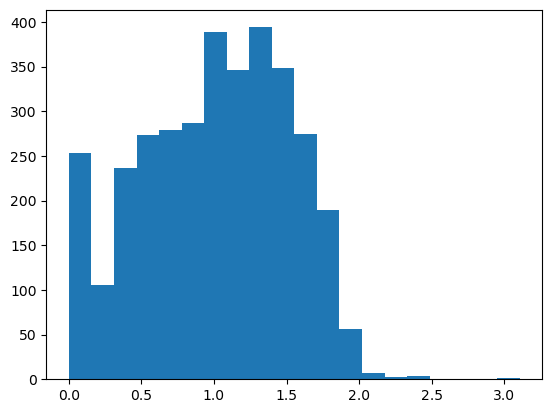

In [14]:
plt.hist(all_ae, bins=20)
#plt.xlim(0,1.0)

In [15]:
good_reps = [rep for rep, likelihood in all_reps_ae_rep_pair if likelihood < 1.0]
bad_reps = [rep for rep, likelihood in all_reps_ae_rep_pair if likelihood > 1.5]

In [16]:
def get_identifer(pep):
    idf = f'{pep.start_residue}-{pep.end_residue} {pep.sequence}'
    return idf

In [17]:
[f"{get_identifer(rep.peptide)}  {rep.timepoint.time}" for rep in good_reps[:4]]

['12-23 AVALSATVSANA  0.0',
 '13-20 VALSATVS  0.0',
 '26-31 KDTIAL  0.0',
 '31-36 LVVSTL  0.0']

In [18]:
[f"{get_identifer(rep.peptide)}  {rep.timepoint.time}" for rep in bad_reps[:4]]

['129-140 DNVLGGKIAGDY  15360.0',
 '262-273 PDQIGAKGVETA  30.0',
 '32-41 VVSTLNNPFF  30.0',
 '35-43 TLNNPFFVS  3840.0']

0.1457518761192673


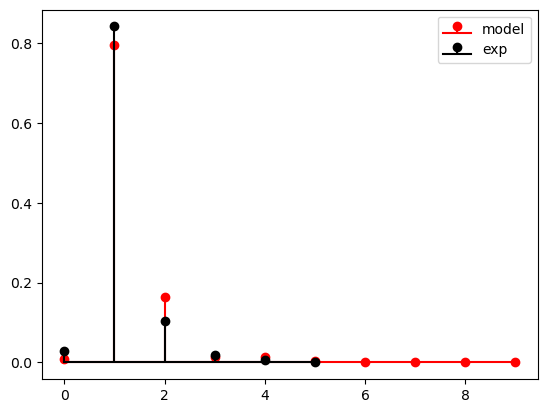

In [190]:
# good fitting

likehood, model_iso, exp_iso =  get_model_exp_iso_envelope(all_reps_ae_rep_pair[250, 0], state, if_plot=True)
print(tools.get_sum_ae(model_iso, exp_iso))

In [89]:
[i.timepoint.time for i in  all_reps_ae_rep_pair[250:300, 0]]

[15360.0,
 3840.0,
 7680.0,
 480.0,
 960.0,
 1920.0,
 1920.0,
 30.0,
 960.0,
 3840.0,
 7680.0,
 1920.0,
 0.0,
 480.0,
 3840.0,
 120.0,
 7680.0,
 960.0,
 480.0,
 1920.0,
 960.0,
 0.0,
 0.0,
 30.0,
 15360.0,
 0.0,
 960.0,
 0.0,
 7680.0,
 3840.0,
 480.0,
 0.0,
 3840.0,
 960.0,
 7680.0,
 0.0,
 15360.0,
 30.0,
 15360.0,
 30.0,
 0.0,
 3840.0,
 0.0,
 7680.0,
 15360.0,
 0.0,
 0.0,
 0.0,
 15360.0,
 0.0]

In [59]:
all_reps_ae_rep_pair.shape

(3447, 2)

1.164246677569739


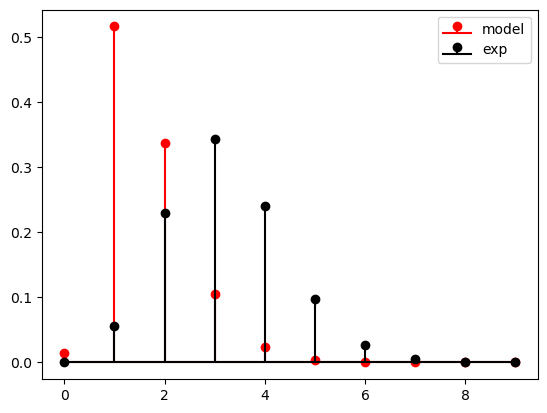

In [76]:
# bad fitting
likehood, model_iso, exp_iso  = get_model_exp_iso_envelope(all_reps_ae_rep_pair[2000, 0], state, if_plot=True)
print(tools.get_sum_ae(model_iso, exp_iso))

In [184]:
a_bad_rep = all_reps_ae_rep_pair[2000, 0]
a_bad_rep.isotope_envelope

a_good_rep = all_reps_ae_rep_pair[0, 0]

In [185]:
def plot_ms_of_all_charge_states(rep):
    colors = ['r', 'b', 'g']
    for ii,i in enumerate(rep.timepoint.replicates):
        plt.stem(i.raw_ms['m/z']*i.charge_state, i.raw_ms['Intensity'],f"{colors[ii]}", label=f'charge {i.charge_state}')

        print(np.sum(np.multiply(i.isotope_envelope, np.array([i for i in range(len(i.isotope_envelope))]))))
    plt.legend()

3.2058407836648373
3.1596653423072154


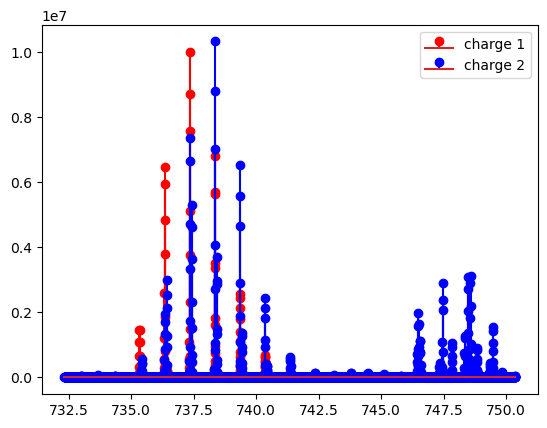

In [186]:
plot_ms_of_all_charge_states(a_bad_rep)

<StemContainer object of 3 artists>

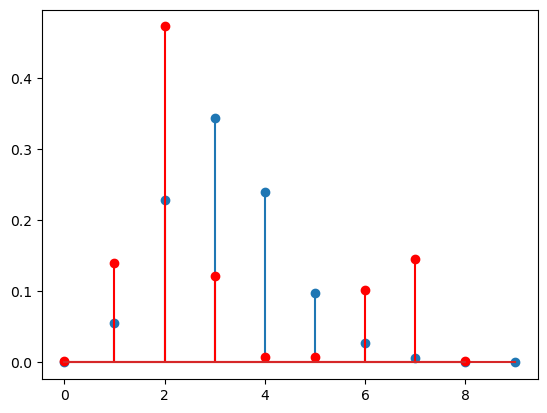

In [187]:
plt.stem(a_bad_rep.timepoint.replicates[0].isotope_envelope)
plt.stem(a_bad_rep.timepoint.replicates[1].isotope_envelope, 'r')

In [160]:
get_identifer(a_bad_rep.peptide)

'183-189 ASQPADF'

In [165]:
a_bad_rep.timepoint.time

3840.0

In [33]:
a_bad_rep.timepoint.replicates[0].raw_ms.describe()

,m/z,Intensity
count,4260.000000,4.260000e+03
mean,741.423776,3.163981e+04
std,4.061200,3.710491e+05
min,734.403200,0.000000e+00
25%,737.906500,0.000000e+00
50%,741.418250,0.000000e+00
75%,744.938225,0.000000e+00
max,748.466600,1.002347e+07


In [34]:
a_bad_rep.timepoint.replicates[1].raw_ms.describe()

,m/z,Intensity
count,3864.000000,3.864000e+03
mean,370.663863,6.093350e+04
std,2.604613,4.440736e+05
min,366.163400,0.000000e+00
25%,368.407925,0.000000e+00
50%,370.659300,0.000000e+00
75%,372.917500,0.000000e+00
max,375.182600,1.033548e+07


<StemContainer object of 3 artists>

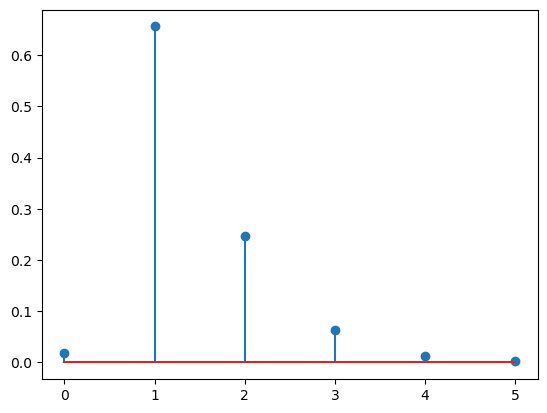

In [35]:
plt.stem(a_bad_rep.peptide.best_t0_replicate.isotope_envelope)

In [285]:
a_bad_rep.sn_ratio

10.719592

In [36]:
sn_ratio_list = []
low_sn_ratio_reps = []
for rep in all_reps_ae_rep_pair[:, 0]:
    iso = tools.get_isotope_envelope(rep)
    sn_ratio_list.append(iso.mean()['sn_ratio'])
    if iso.mean()['sn_ratio'] < 10:
        low_sn_ratio_reps.append(rep)
    #print(iso.mean()['sn_ratio'])

(array([ 58., 108., 252., 476., 544., 532., 463., 287., 236., 162., 128.,
         91.,  52.,  22.,  18.,   7.,   2.,   5.,   1.,   3.]),
 array([ 13.57453251,  21.37244697,  29.17036142,  36.96827588,
         44.76619034,  52.5641048 ,  60.36201925,  68.15993371,
         75.95784817,  83.75576262,  91.55367708,  99.35159154,
        107.149506  , 114.94742045, 122.74533491, 130.54324937,
        138.34116383, 146.13907828, 153.93699274, 161.7349072 ,
        169.53282166]),
 <BarContainer object of 20 artists>)

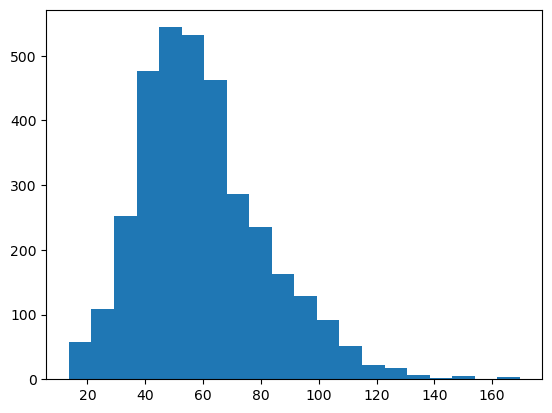

In [39]:
plt.hist(sn_ratio_list, bins=20)